<a href="https://colab.research.google.com/github/dirknbr/numpyro-examples/blob/main/lognormal_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Log normal model and prediction

Our true model is lognormal, we have a relationship between x and y. We estimate a naive normal model and the proper lognormal model. We check
posterior predictions.

In [49]:
!pip install numpyro

17.70116583575283 0.5223152095199134


(array([0.03784577, 0.00630763, 0.00194081, 0.0004852 , 0.        ,
        0.0004852 , 0.        , 0.0004852 , 0.0004852 , 0.0004852 ]),
 array([  0.52231521,  21.13227859,  41.74224197,  62.35220535,
         82.96216873, 103.57213211, 124.18209549, 144.79205887,
        165.40202225, 186.01198563, 206.62194901]),
 <a list of 10 Patch objects>)

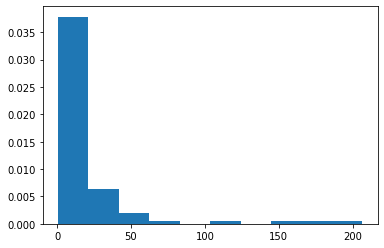

In [50]:
import numpy as np
import jax.numpy as jnp
from jax import random
import arviz
import matplotlib.pyplot as plt

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive

n = 100
x = np.random.normal(1, 1, size=n)
y = np.exp(np.random.normal(1 + x, 1.1, size=n))

print(y.mean(), y.min())
plt.hist(y, density=True)

In [59]:
# theoretical mean
mu = (1 + x).mean()
np.exp(mu + 1.1 ** 2 / 2)

15.063227621444266

In [51]:
# model 1 is normal, model 2 is lognormal

def model1(x=None, y=None):
  a = numpyro.sample('a', dist.Normal(0, 1))
  b = numpyro.sample('b', dist.Normal(0, 1))
  sigma = numpyro.sample('sigma', dist.Gamma(2, 1))
  mu = a + b * x
  pred = numpyro.sample('pred', dist.Normal(mu, sigma), obs=y)

def model2(x=None, y=None):
  a = numpyro.sample('a', dist.Normal(0, 1))
  b = numpyro.sample('b', dist.Normal(0, 1))
  sigma = numpyro.sample('sigma', dist.Gamma(2, 1))
  mu = a + b * x
  pred = numpyro.sample('pred', dist.LogNormal(mu, sigma), obs=y)

In [52]:
kernel1 = NUTS(model1)
mcmc1 = MCMC(kernel1, num_warmup=500, num_samples=1000, num_chains=2)
mcmc1.run(random.PRNGKey(0), x, y)
mcmc1.print_summary()
samples1 = mcmc1.get_samples()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:280: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 1500/1500 [00:00<00:00, 6170.79it/s, 7 steps of size 9.16e-01. acc. prob=0.88]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.38      0.95      1.35     -0.16      2.93   1634.31      1.00
         b      3.14      0.93      3.16      1.45      4.49   1830.23      1.00
     sigma     30.50      1.92     30.45     27.29     33.42   1894.84      1.00

Number of divergences: 0


In [53]:
kernel2 = NUTS(model2)
mcmc2 = MCMC(kernel2, num_warmup=500, num_samples=1000, num_chains=2)
mcmc2.run(random.PRNGKey(0), x, y)
mcmc2.print_summary()
samples2 = mcmc2.get_samples()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:280: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 1500/1500 [00:00<00:00, 5646.04it/s, 7 steps of size 5.28e-01. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.81      0.13      0.81      0.60      1.04    781.65      1.00
         b      1.02      0.09      1.02      0.87      1.18    972.70      1.00
     sigma      0.90      0.06      0.90      0.79      1.00   1301.15      1.00

Number of divergences: 0


r2        0.009092
r2_std    0.000000
dtype: float64
-0.97495306


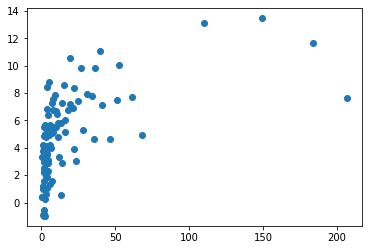

In [60]:
# make predictions, we also get negative predictions

predf1 = Predictive(model1, samples1)
pred1 = predf1(random.PRNGKey(0), x=x)['pred']
pred1 = pred1.mean(axis=0)
print(arviz.r2_score(y, pred1))
print(pred1.min())
plt.scatter(y, pred1)

r2        0.47921
r2_std    0.00000
dtype: float64


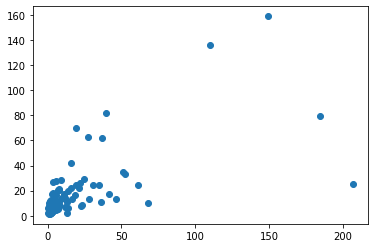

In [55]:
predf2 = Predictive(model2, samples2)
pred2 = predf2(random.PRNGKey(0), x=x)['pred']
pred2 = pred2.mean(axis=0)
print(arviz.r2_score(y, pred2))
plt.scatter(y, pred2)

(120,)


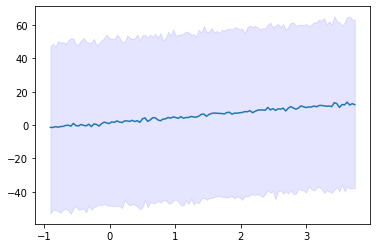

In [56]:
# CI and counterfactual x
# https://www.hellocybernetics.tech/entry/2020/02/23/034551

xlin = np.linspace(x.min(), x.max(), 120)
pred1_lin = predf1(random.PRNGKey(0), x=xlin)['pred']
pred1_lin_mean = pred1_lin.mean(axis=0)
pred1_lin_low = np.quantile(pred1_lin, .05, axis=0)
pred1_lin_up = np.quantile(pred1_lin, .95, axis=0)

print(pred1_lin_mean.shape)

fig, ax = plt.subplots()
ax.plot(xlin, pred1_lin_mean)
ax.fill_between(xlin, pred1_lin_low, pred1_lin_up, color='b', alpha=.1)

(120,)


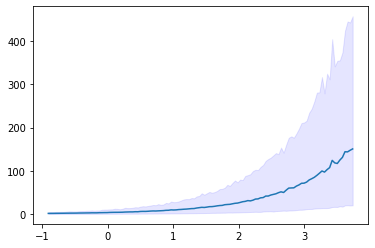

In [57]:
pred2_lin = predf2(random.PRNGKey(0), x=xlin)['pred']
pred2_lin_mean = pred2_lin.mean(axis=0)
pred2_lin_low = np.quantile(pred2_lin, .05, axis=0)
pred2_lin_up = np.quantile(pred2_lin, .95, axis=0)

print(pred2_lin_mean.shape)

fig, ax = plt.subplots()
ax.plot(xlin, pred2_lin_mean)
ax.fill_between(xlin, pred2_lin_low, pred2_lin_up, color='b', alpha=.1)